<a href="https://colab.research.google.com/github/IsraelPeled/Image-Colorization/blob/main/GreyToColorCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The dataset that we used in this project:**
[https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization)

In [ ]:
! unzip -q "/content/drive/MyDrive/Deep Learning/GreyToColor/archive.zip" -d './'

#**Imports**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

In [ ]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#**Data Preparation**

For the data preparation phase, We created a custom dataset using PyTorch’s `Dataset` class, called `LandscapeDataset`. This dataset loads images from a directory and applies transformations to them. The dataset includes images in both color and grayscale, where the goal is to use the grayscale images as input and predict the corresponding color images.

### Dataset Creation

The `LandscapeDataset` class is initialized with a transformation function, and it loads the images from two subdirectories: `color` for color images and `gray` for grayscale images. The images are read using `read_image` from `torchvision`, and their pixel values are normalized by dividing them by 255.


In [ ]:
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = "./landscape Images"
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

### Image Transformation

For the image transformation, we used `torchvision.transforms.Compose` to apply resizing, specifically scaling each image to a size of 150x150 pixels.

After creating the dataset, we split it into training, validation, and test sets with proportions of 70%, 15%, and 15%, respectively. This was done using the `random_split` method from PyTorch’s `torch.utils.data`.

Finally, we created separate data loaders for each split using PyTorch’s `DataLoader` to handle batching and shuffling during training and evaluation.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])

dataset = LandscapeDataset(transform=transform)

train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(MANUAL_SEED))

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

### Displaying Sample Images

To visualize the images and ensure that the data preprocessing steps are correctly applied, we wrote a function `show_images` to display sample grayscale and color images. This allows us to inspect the data being passed to the model during training.

The function `show_images` takes two inputs: the color images and the corresponding grayscale images. It uses `matplotlib` to display the images in a 5x2 grid, where each row contains one grayscale image and one color image.

The images are displayed by first converting the tensor dimensions to `(height, width, channels)` using the `permute` function and then converting the tensor to a NumPy array to be compatible with `matplotlib`. The grayscale images are displayed using a grayscale colormap, while the color images are displayed in their natural color.


In [ ]:
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

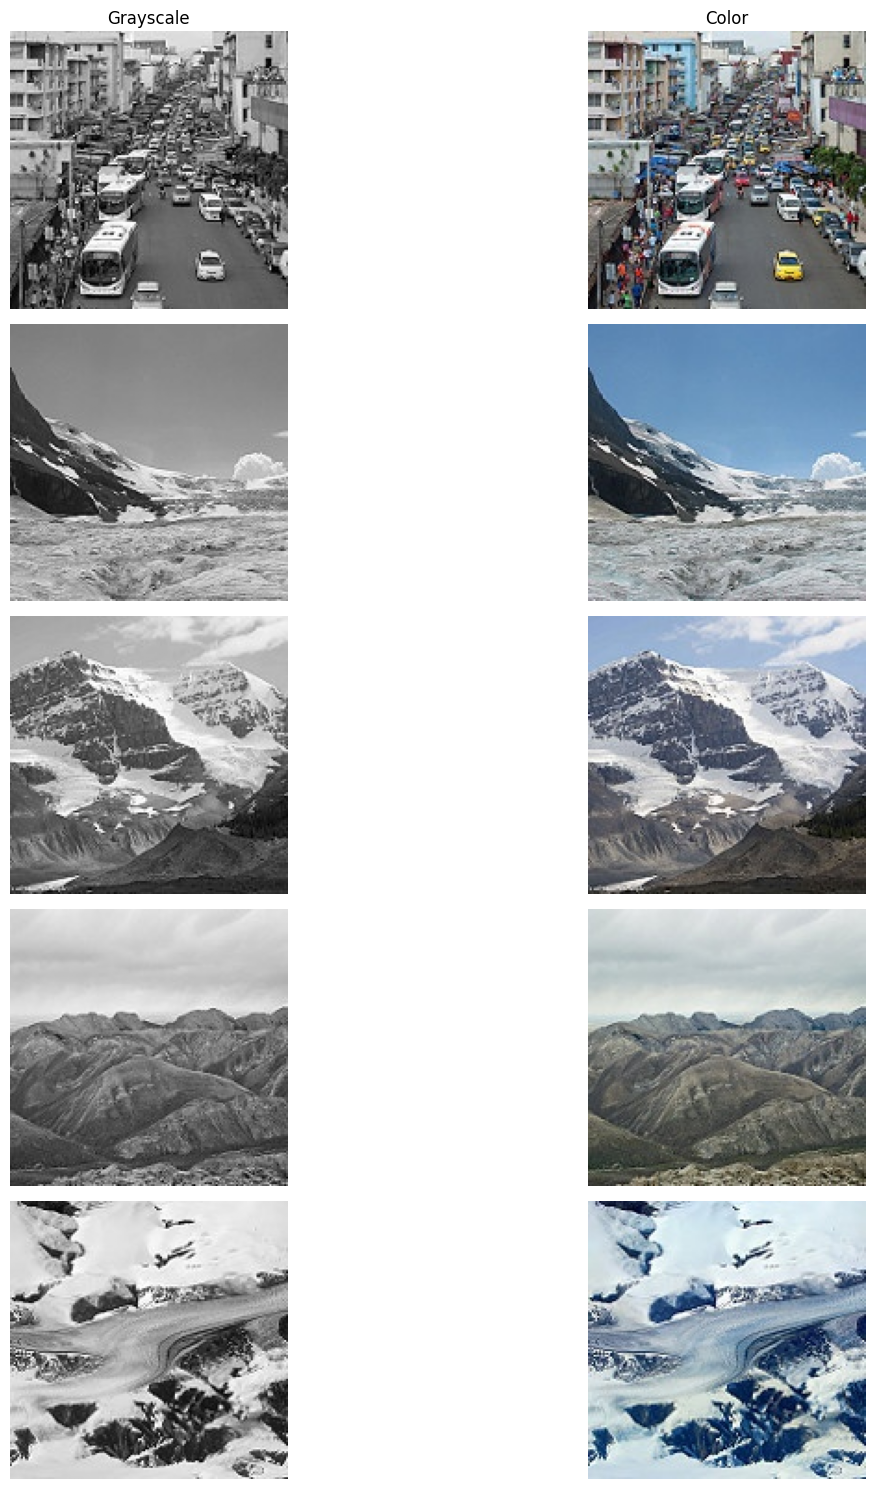

In [ ]:
color, gray = next(iter(trainloader))
show_images(color, gray)

#**Model Building:**

### **Model Architecture**

#### **How We Chose the Model**

When selecting the best model for image colorization, we considered different deep learning approaches. Since this task requires both understanding image features and reconstructing them with added color, we needed a model that could extract important details from grayscale images while also generating realistic color outputs.

Traditional CNNs (used for classification tasks) analyze images and recognize patterns, but they do not generate new pixel values, which is essential for colorization.


So we chose a convolutional autoencoder (ColorAutoEncoder) because autoencoders are specifically designed to compress and then reconstruct images while learning meaningful patterns from data. The encoder compresses the grayscale image into a lower-dimensional representation, capturing essential features, while the decoder reconstructs the image and predicts the missing color information. To enhance accuracy, we incorporated skip connections, which help preserve spatial details lost during compression. This architecture strikes a balance between simplicity, computational efficiency, and effective learning, making it well-suited for image colorization.

###**Our Project Architecture:**

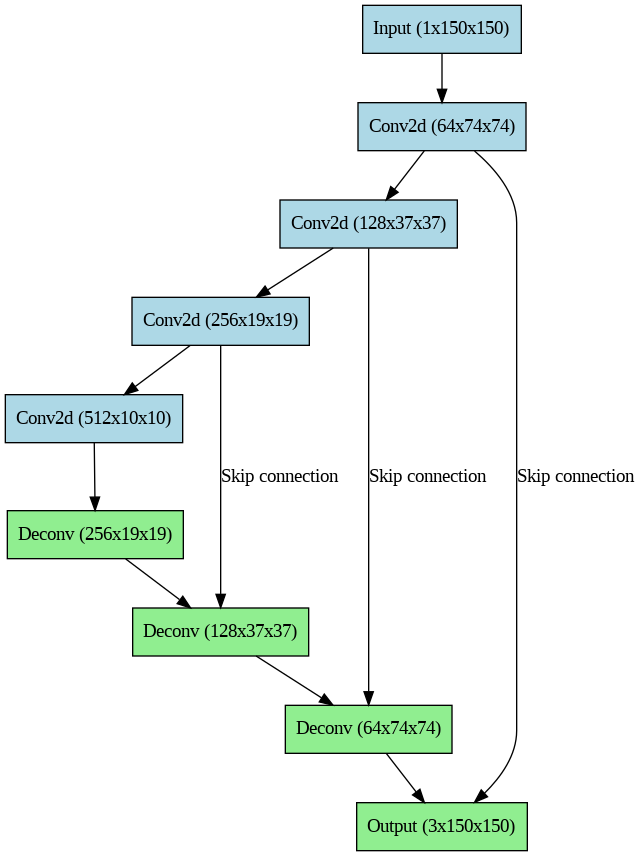

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.001

## Convolution Formula


$n_{out} = ⌊\frac{n_{in}+2p-k}{s}⌋+1$

$$$$

$H_{in/out}=W_{in/out}=n_{in/out}$

when:
- $H_{in/out}$: image Hight.
- $W_{in/out}$: image Width.
- $n_{in}$: numbers of input features.
- $n_{out}$: numbers of output features.
- $k$: convolution kernel size.
- $p$: convolution padding size.
- $s$: convolution stride size.


In [ ]:
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150


        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x19
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Up sample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

#**Training:**

The model was trained using Mean Squared Error (MSE) loss, which measures how different the predicted colors are from the real ones. It used the Adam optimizer with a learning rate of 0.001 to improve accuracy. Training lasted 10 epochs, where the model processed grayscale images, predicted colors, compared them to the real ones, and adjusted itself. After each round, the model was tested on new images to check if it was improving. Over time, the loss decreased, showing that the model was learning well.


In [ ]:
model = ColorAutoEncoder().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Number of trainable parameters of this model are: {total_params:,}")
print(f'\n{model}')

Total Number of trainable parameters of this model are: 3,470,659

ColorAutoEncoder(
  (down1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (down2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up2): ConvTranspose2d(512, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up3): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up4): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train_func(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for color_img, gray_img in trainloader:
        gray_img, color_img = gray_img.to(device), color_img.to(device)
        optimizer.zero_grad()
        predictions = model(gray_img)
        loss = criterion(predictions, color_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    return avg_train_loss

def validate_func(model, valloader, criterion):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for color_img, gray_img in valloader:
            gray_img, color_img = gray_img.to(device), color_img.to(device)
            predictions = model(gray_img)
            loss = criterion(predictions, color_img)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valloader)
    return avg_val_loss

def train_and_validate_model(model, trainloader, valloader, criterion, optimizer, epochs):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        avg_train_loss = train_func(model, trainloader, criterion, optimizer)
        train_losses.append(avg_train_loss)
        avg_val_loss = validate_func(model, valloader, criterion)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_and_validate_model(model, trainloader, valloader, criterion, optimizer, EPOCHS)

Epoch 1/10 - Training Loss: 0.0204 - Validation Loss: 0.0113
Epoch 2/10 - Training Loss: 0.0102 - Validation Loss: 0.0099
Epoch 3/10 - Training Loss: 0.0086 - Validation Loss: 0.0084
Epoch 4/10 - Training Loss: 0.0080 - Validation Loss: 0.0077
Epoch 5/10 - Training Loss: 0.0075 - Validation Loss: 0.0077
Epoch 6/10 - Training Loss: 0.0074 - Validation Loss: 0.0073
Epoch 7/10 - Training Loss: 0.0070 - Validation Loss: 0.0072
Epoch 8/10 - Training Loss: 0.0070 - Validation Loss: 0.0072
Epoch 9/10 - Training Loss: 0.0070 - Validation Loss: 0.0070
Epoch 10/10 - Training Loss: 0.0068 - Validation Loss: 0.0071


#**Testing:**

After training, the model was tested on a new set of grayscale images it had never seen before. It predicted the colors, and the results were compared to the real images using **MSE** loss to measure accuracy. The model performed well on landscapes but had some difficulty with fine details. A side-by-side comparison of the grayscale input, real color image, and the model's output was used to visually evaluate the results.

In [ ]:
def test_func(model, testloader, criterion):
    model.to(device)
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
            color_img = color_img.to(device)
            gray_img = gray_img.to(device)

            prediction = model(gray_img)

            loss = criterion(prediction, color_img)
            total_loss += loss.item()
    avg_test_loss = total_loss / len(testloader)
    return avg_test_loss

avg_test_loss = test_func(model, testloader, criterion)
print(f"Total Testing loss is: {avg_test_loss}")

  0%|          | 0/34 [00:00<?, ?it/s]

Total Testing loss is: 0.0068973853280219965


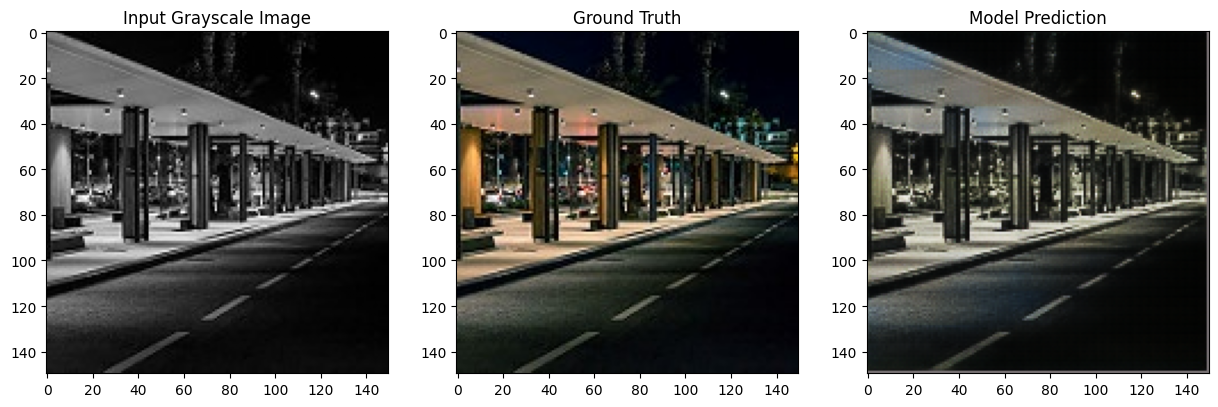

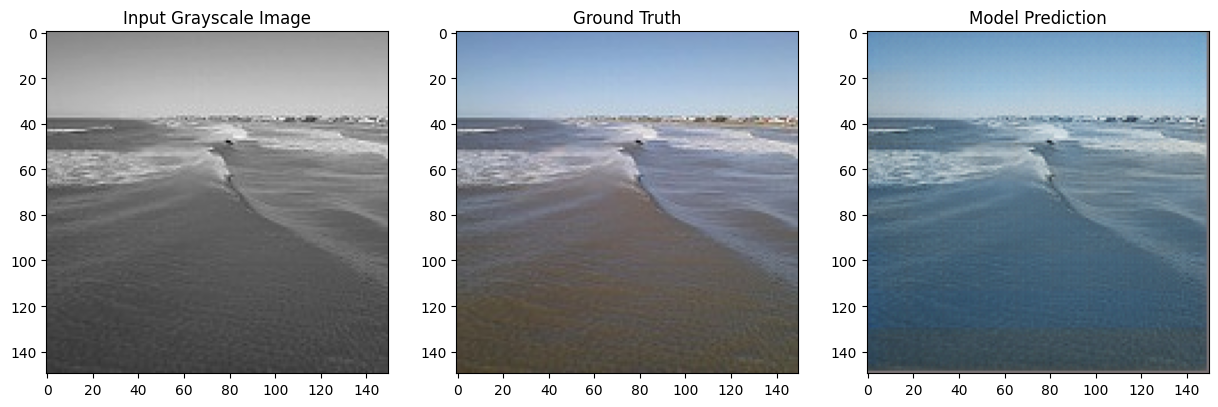

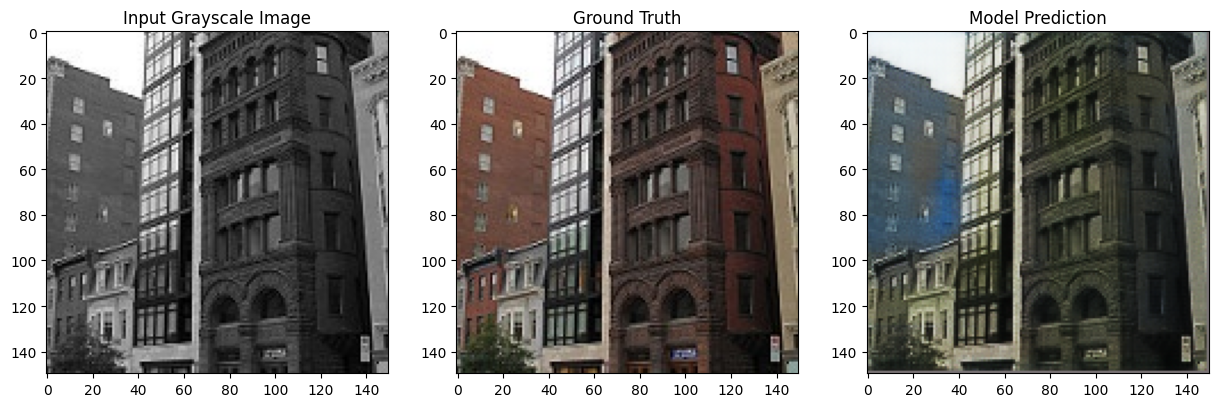

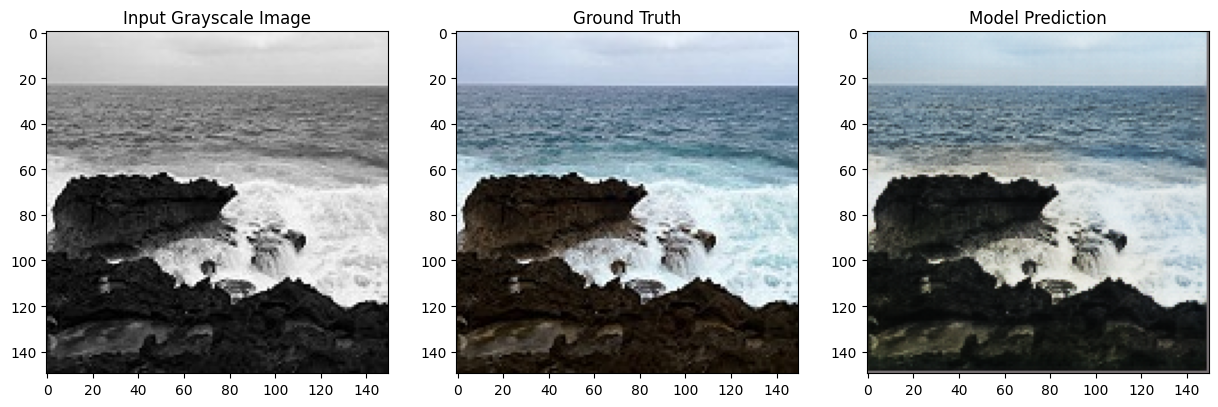

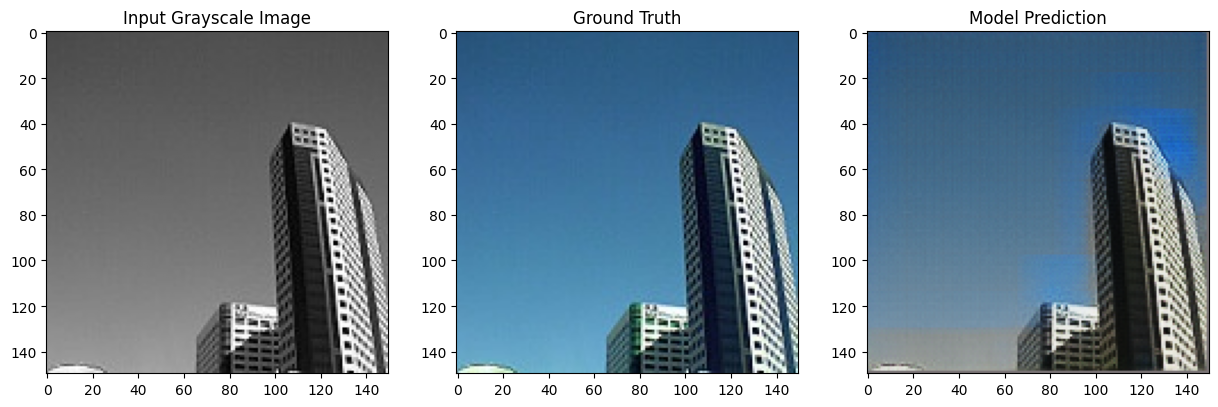

In [ ]:
def show_predictions(model, testloader, device, num):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for idx, (color_img, gray_img) in enumerate(testloader):
            color_img = color_img.to(device)
            gray_img = gray_img.to(device)
            prediction = model(gray_img)

            # Assuming you have 3 images in each batch
            fig, axes = plt.subplots(1, 3,figsize=(15,5))

            axes[0].imshow(gray_img[0].cpu().squeeze(), cmap='gray')
            axes[0].set_title("Input Grayscale Image")

            axes[1].imshow(color_img[0].permute(1,2,0).cpu())
            axes[1].set_title("Ground Truth")

            axes[2].imshow(prediction[0].permute(1,2,0).cpu())
            axes[2].set_title("Model Prediction")

            plt.show()
            if idx >= num-1 : # show only num examples
              break


show_predictions(model, testloader, device, 5)

Finally, the trained model was saved as `colorization_model.pth` and tested on additional images, confirming its ability to generate realistic colors.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning/GreyToColor/colorization_model.pth')

## **Discussion**
The model performed well in coloring grayscale images, especially for landscapes and simple patterns, producing realistic colors. However, it struggled with complex objects and fine details, sometimes generating blurry or inaccurate colors. This is likely due to the limited diversity in the training dataset, causing the model to predict certain colors more frequently. Throughout training, the loss consistently decreased, indicating that the model was learning, but signs of overfitting appeared, meaning it performed better on training images than on new ones. Since the model does not "understand" colors like humans do, it learns based on patterns in the dataset. Overall, it performs well for general colorization but requires further refinement for improved color accuracy and fine details.



### Test with image that not in the Dataset

<ipython-input-20-10bd4c5e10cc>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/GreyToColor/colorizat

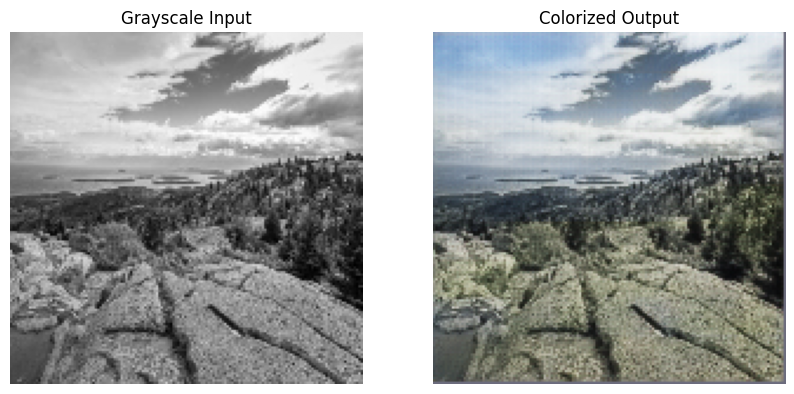

In [ ]:
# Load the saved model
model = ColorAutoEncoder().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/GreyToColor/colorization_model.pth'))
model.eval()

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Deep Learning/GreyToColor/unchecked images/istockphoto-1446618872-612x612.png'
input_image = read_image(image_path) / 255
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
    transforms.Grayscale()
])
input_tensor = transform(input_image).unsqueeze(0).to(device)


# Make a prediction
with torch.no_grad():
    predicted_image = model(input_tensor)

# Display the original grayscale and the colorized image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Grayscale Input')
plt.imshow(input_tensor.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Colorized Output')
plt.imshow(predicted_image.squeeze().permute(1, 2, 0).cpu())
plt.axis('off')

plt.show()

## **Conclusion**
This project demonstrated that deep learning can effectively add color to black-and-white images by learning patterns from a dataset. The ColorAutoEncoder was trained on 7,000 grayscale and color image pairs, enabling it to predict realistic colorized versions of grayscale inputs. While the model successfully colorized many images, it still requires improvements in color accuracy and sharpness, especially for objects with complex details. This technology has significant potential in automated image colorization, restoring old photographs, enhancing medical imaging, and improving AI-generated visuals.


## **Possible Improvements**
* Train on a larger dataset - A more diverse dataset will help the model learn a wider range of colors and details.

* Use a more advanced model – Implementing Generative Adversarial Networks (GANs) could improve color sharpness and realism.

* Fine-tune hyperparameters - Adjusting settings such as batch size, learning rate, and the number of layers could optimize performance.

* Incorporate attention mechanisms - Adding attention layers can help the model focus on important areas, improving detail retention.

* Enhance training strategies - Techniques such as data augmentation and transfer learning could help the model generalize better to new images.

(By implementing these improvements, the model can achieve more precise and natural-looking colorization, making it even more effective for real-world applications.)

# **Hypertuning**

## **SGD Optimizer**

In [ ]:
hyperparams_sgd = {
    "optimizer": "SGD",
    "learning_rate": [0.01, 0.001, 0.0001],
    "momentum": [0.8, 0.9, 0.99]
}

results_sgd = {}

for lr in hyperparams_sgd["learning_rate"]:
    for momentum in hyperparams_sgd["momentum"]:
        key = f"SGD - LR {lr} - Momentum {momentum}"
        print(f"\nTraining with {key}\n")

        model = ColorAutoEncoder().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        train_losses, val_losses = train_and_validate_model(model, trainloader, valloader, criterion, optimizer, EPOCHS)
        results_sgd[key] = (train_losses, val_losses)


Training with SGD - LR 0.01 - Momentum 0.8

Epoch 1/10 - Training Loss: 0.0759 - Validation Loss: 0.0714
Epoch 2/10 - Training Loss: 0.0653 - Validation Loss: 0.0617
Epoch 3/10 - Training Loss: 0.0570 - Validation Loss: 0.0540
Epoch 4/10 - Training Loss: 0.0499 - Validation Loss: 0.0471
Epoch 5/10 - Training Loss: 0.0434 - Validation Loss: 0.0408
Epoch 6/10 - Training Loss: 0.0377 - Validation Loss: 0.0355
Epoch 7/10 - Training Loss: 0.0330 - Validation Loss: 0.0312
Epoch 8/10 - Training Loss: 0.0291 - Validation Loss: 0.0276
Epoch 9/10 - Training Loss: 0.0262 - Validation Loss: 0.0250
Epoch 10/10 - Training Loss: 0.0240 - Validation Loss: 0.0232

Training with SGD - LR 0.01 - Momentum 0.9

Epoch 1/10 - Training Loss: 0.0728 - Validation Loss: 0.0659
Epoch 2/10 - Training Loss: 0.0582 - Validation Loss: 0.0524
Epoch 3/10 - Training Loss: 0.0458 - Validation Loss: 0.0405
Epoch 4/10 - Training Loss: 0.0355 - Validation Loss: 0.0315
Epoch 5/10 - Training Loss: 0.0283 - Validation Loss: 0

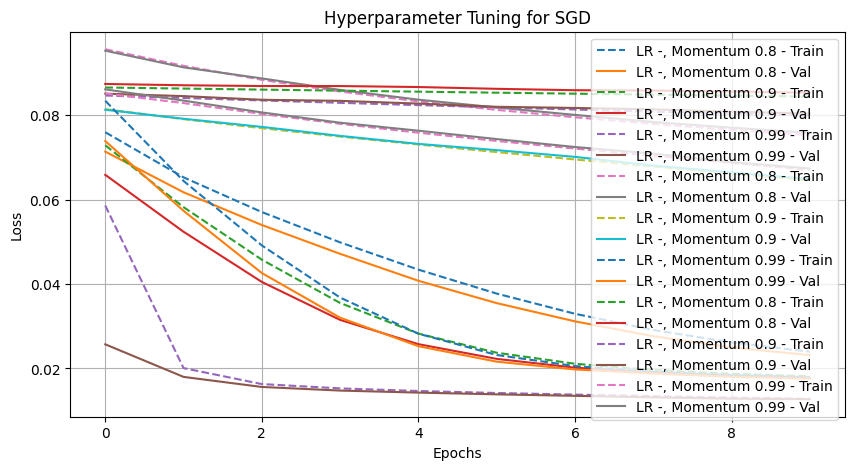


Best SGD parameters: SGD - LR 0.01 - Momentum 0.99


In [ ]:
plt.figure(figsize=(10, 5))

for key, (train_losses, val_losses) in results_sgd.items():
    lr, momentum = key.split(" ")[-3], key.split(" ")[-1]
    plt.plot(train_losses, label=f"LR {lr}, Momentum {momentum} - Train", linestyle="dashed")
    plt.plot(val_losses, label=f"LR {lr}, Momentum {momentum} - Val")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Hyperparameter Tuning for SGD")
plt.legend()
plt.grid()
plt.show()

best_sgd = min(results_sgd, key=lambda k: min(results_sgd[k][1]))
print(f"\nBest SGD parameters: {best_sgd}")

## **ADAM Optimizer**

In [ ]:
hyperparams_adam = {
    "optimizer": "Adam",
    "learning_rate": [0.01, 0.001, 0.0001]
}

results_adam = {}

for lr in hyperparams_adam["learning_rate"]:
    key = f"Adam - LR {lr}"
    print(f"\nTraining with {key}\n")

    model = ColorAutoEncoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = train_and_validate_model(model, trainloader, valloader, criterion, optimizer, EPOCHS)
    results_adam[key] = (train_losses, val_losses)


Training with Adam - LR 0.01

Epoch 1/10 - Training Loss: 0.0177 - Validation Loss: 0.0092
Epoch 2/10 - Training Loss: 0.0086 - Validation Loss: 0.0084
Epoch 3/10 - Training Loss: 0.0081 - Validation Loss: 0.0082
Epoch 4/10 - Training Loss: 0.0076 - Validation Loss: 0.0072
Epoch 5/10 - Training Loss: 0.0074 - Validation Loss: 0.0078
Epoch 6/10 - Training Loss: 0.0071 - Validation Loss: 0.0071
Epoch 7/10 - Training Loss: 0.0071 - Validation Loss: 0.0072
Epoch 8/10 - Training Loss: 0.0070 - Validation Loss: 0.0077
Epoch 9/10 - Training Loss: 0.0068 - Validation Loss: 0.0075
Epoch 10/10 - Training Loss: 0.0068 - Validation Loss: 0.0072

Training with Adam - LR 0.001

Epoch 1/10 - Training Loss: 0.0197 - Validation Loss: 0.0115
Epoch 2/10 - Training Loss: 0.0104 - Validation Loss: 0.0095
Epoch 3/10 - Training Loss: 0.0087 - Validation Loss: 0.0084
Epoch 4/10 - Training Loss: 0.0080 - Validation Loss: 0.0081
Epoch 5/10 - Training Loss: 0.0076 - Validation Loss: 0.0075
Epoch 6/10 - Training

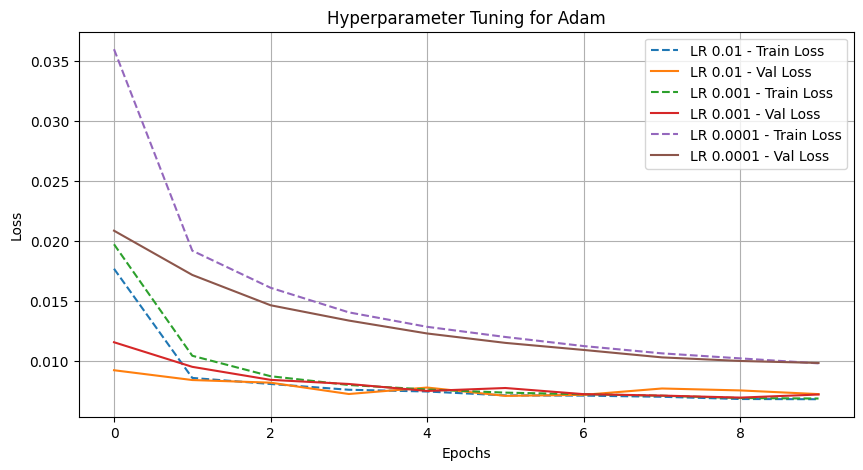


Best learning rate for Adam: Adam - LR 0.001


In [ ]:
plt.figure(figsize=(10, 5))

for key, (train_losses, val_losses) in results_adam.items():
    lr = key.split(" ")[-1]  # חילוץ ה-learning rate מהשם
    plt.plot(train_losses, label=f"LR {lr} - Train Loss", linestyle="dashed")
    plt.plot(val_losses, label=f"LR {lr} - Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Hyperparameter Tuning for Adam")
plt.legend()
plt.grid()
plt.show()

best_lr = min(results_adam, key=lambda k: min(results_adam[k][1]))
print(f"\nBest learning rate for Adam: {best_lr}")

## **RMSprop Optimizer**

In [ ]:
hyperparams_RMSprop = {
    "optimizer": "RMSprop",
    "learning_rate": [0.01, 0.001, 0.0001],
    "momentum": [0.8, 0.9, 0.99]
}

results_RMSprop = {}

for lr in hyperparams_RMSprop["learning_rate"]:
    for momentum in hyperparams_RMSprop["momentum"]:
        key = f"RMSprop - LR {lr} - Momentum {momentum}"
        print(f"\nTraining with {key}\n")

        model = ColorAutoEncoder().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)

        train_losses, val_losses = train_and_validate_model(model, trainloader, valloader, criterion, optimizer, EPOCHS)
        results_RMSprop[key] = (train_losses, val_losses)


Training with RMSprop - LR 0.01 - Momentum 0.8

Epoch 1/10 - Training Loss: 0.2864 - Validation Loss: 0.2913
Epoch 2/10 - Training Loss: 0.2876 - Validation Loss: 0.2921
Epoch 3/10 - Training Loss: 0.2876 - Validation Loss: 0.2916
Epoch 4/10 - Training Loss: 0.2876 - Validation Loss: 0.2918
Epoch 5/10 - Training Loss: 0.2876 - Validation Loss: 0.2919
Epoch 6/10 - Training Loss: 0.2876 - Validation Loss: 0.2914
Epoch 7/10 - Training Loss: 0.2876 - Validation Loss: 0.2915
Epoch 8/10 - Training Loss: 0.2876 - Validation Loss: 0.2916
Epoch 9/10 - Training Loss: 0.2876 - Validation Loss: 0.2913
Epoch 10/10 - Training Loss: 0.2876 - Validation Loss: 0.2919

Training with RMSprop - LR 0.01 - Momentum 0.9

Epoch 1/10 - Training Loss: 0.3310 - Validation Loss: 0.3335
Epoch 2/10 - Training Loss: 0.3325 - Validation Loss: 0.3334
Epoch 3/10 - Training Loss: 0.3325 - Validation Loss: 0.3336
Epoch 4/10 - Training Loss: 0.3423 - Validation Loss: 0.3609
Epoch 5/10 - Training Loss: 0.3620 - Validation

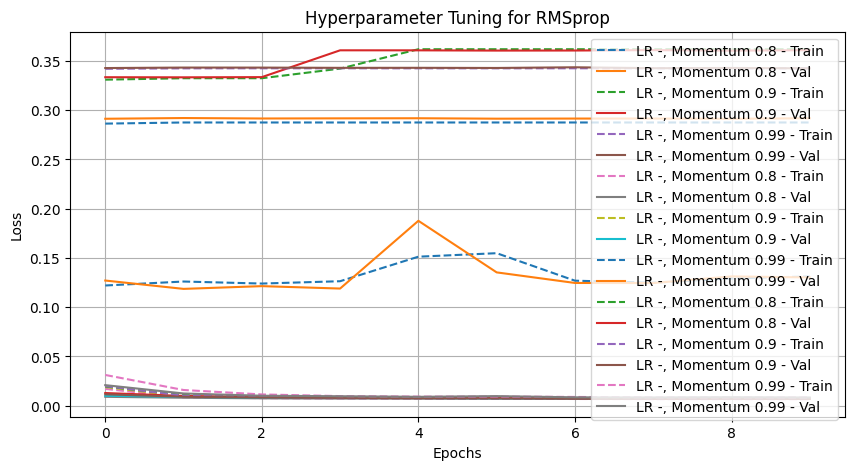


Best RMSprop parameters: RMSprop - LR 0.001 - Momentum 0.8


In [ ]:
plt.figure(figsize=(10, 5))

for key, (train_losses, val_losses) in results_RMSprop.items():
    lr, momentum = key.split(" ")[-3], key.split(" ")[-1]
    plt.plot(train_losses, label=f"LR {lr}, Momentum {momentum} - Train", linestyle="dashed")
    plt.plot(val_losses, label=f"LR {lr}, Momentum {momentum} - Val")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Hyperparameter Tuning for RMSprop")
plt.legend()
plt.grid()
plt.show()


best_RMSprop = min(results_RMSprop, key=lambda k: min(results_RMSprop[k][1]))
print(f"\nBest RMSprop parameters: {best_RMSprop}")

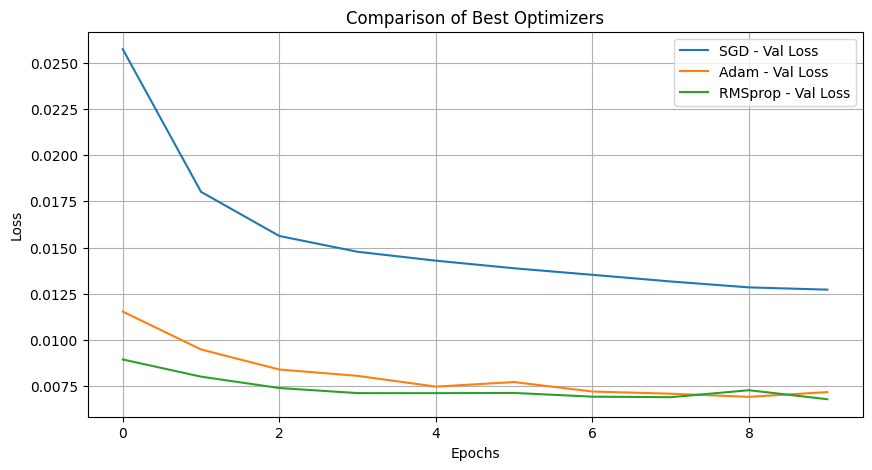

In [ ]:
best_results = {
    "SGD": results_sgd[best_sgd],
    "Adam": results_adam[best_lr],
    "RMSprop": results_RMSprop[best_RMSprop]
}

plt.figure(figsize=(10, 5))

for optimizer, (train_losses, val_losses) in best_results.items():
    #plt.plot(train_losses, label=f"{optimizer} - Train Loss", linestyle="dashed")
    plt.plot(val_losses, label=f"{optimizer} - Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Best Optimizers")
plt.legend()
plt.grid()
plt.show()


# **GAN Colorization**

Generative Adversarial Networks (GANs) - Connection Between Generator and Discriminator

A Generative Adversarial Network (GAN) consists of two competing neural networks: the Generator and the Discriminator, which work together in a zero-sum game to improve image colorization quality.

## **How They Work Together:**

### **Generator:**

Takes a grayscale image (1xHxW) as input.
Converts it into a colorized image (3xHxW) using a U-Net-like CNN architecture.
Tries to generate images that are as realistic as possible.

### **Discriminator:**

Receives both real images (ground truth) and fake images (generated by the Generator).
Classifies each image as real (1) or fake (0) using a CNN-based binary classifier.
Helps refine the Generator by providing feedback.


### **Training Process (Adversarial Learning):**
The Generator continuously improves by learning from the Discriminator's feedback.
The Discriminator gets better at detecting fakes.
Over time, the Generator creates highly realistic colorized images that can fool the Discriminator.

### **Final Goal:**
The ideal GAN reaches a point where the Generator produces colorized images so realistic that the Discriminator can no longer distinguish them from real images. This results in high-quality, natural-looking colorized images.

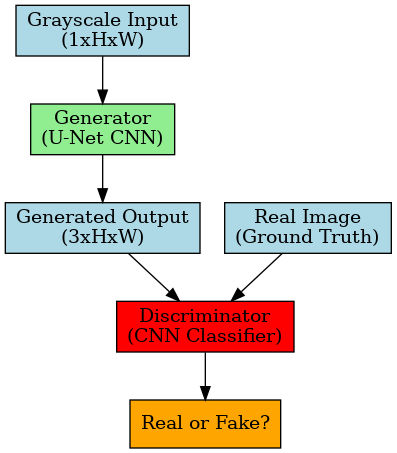

### **Generator Model - Brief Explanation**

The Generator Model in a GAN for image colorization is responsible for converting a grayscale image (1 channel) into a full-color RGB image (3 channels). It follows a U-Net-like CNN architecture, which helps in both downsampling (encoding) and upsampling (decoding) while preserving spatial details.

#### **How It Work**:
* **Input:** A grayscale image (1xHxW).

* **Downsampling (Encoding):** Several convolutional layers extract features and gradually reduce the spatial size.
Bottleneck: A compressed latent representation of the image.

* **Upsampling (Decoding):** Transposed convolutional layers reconstruct the image into an RGB format.
Skip Connections: Features from earlier layers are directly connected to later layers, helping preserve important details.

* **Output:** A colorized image (3xHxW) that looks realistic.

The Generator "learns" to colorize images by training against a Discriminator, which tries to distinguish real color images from generated ones. Over time, the Generator improves, producing realistic colorized images.

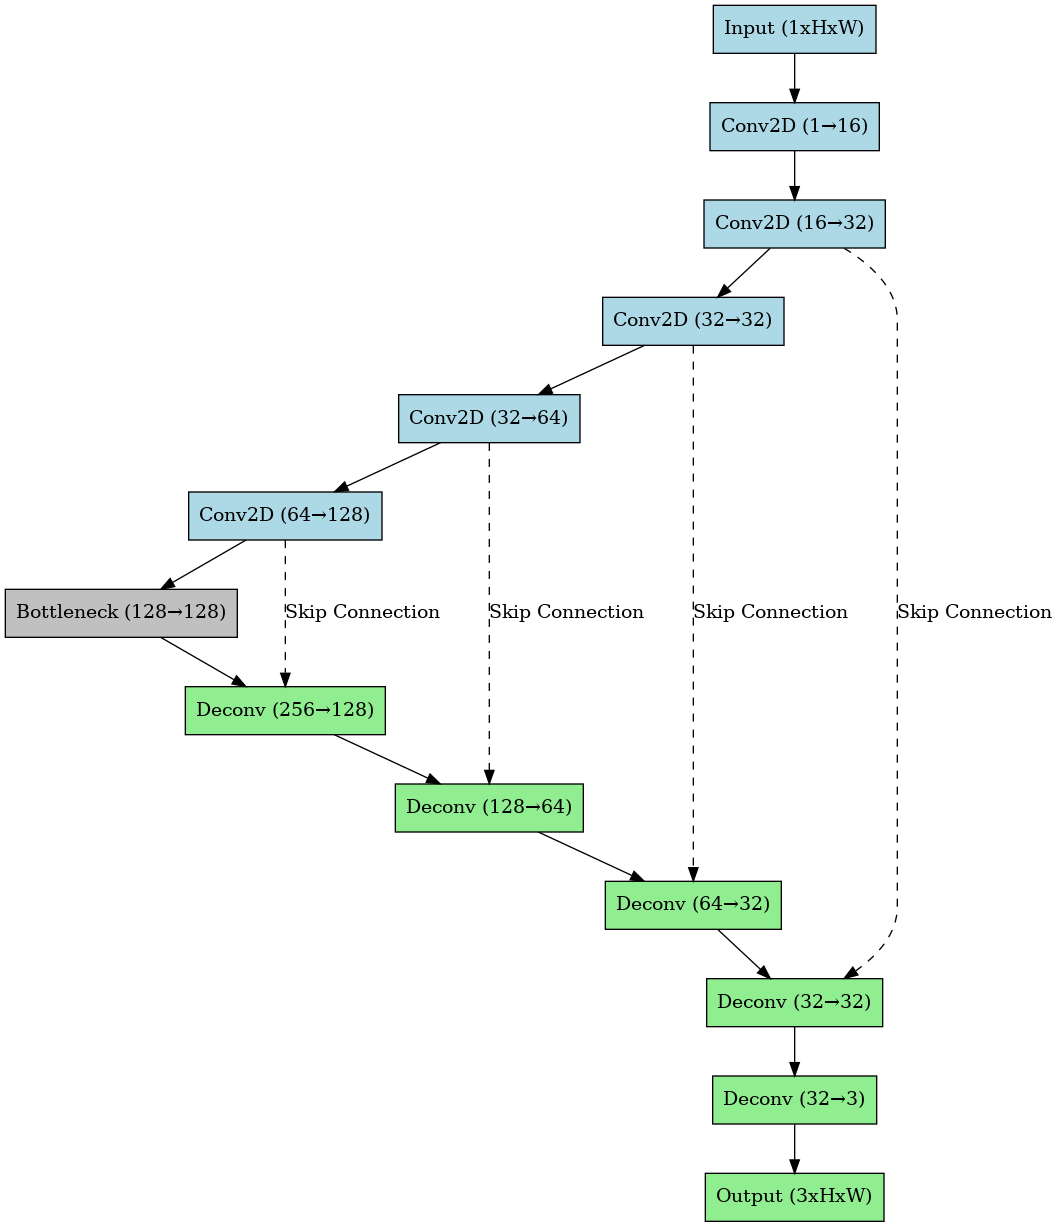

In [ ]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()

        # Down-sampling layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.LeakyReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.LeakyReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.LeakyReLU()
        )

        # Bottleneck layer
        self.bottleneck = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bottleneck_activation = nn.Tanh()

        # Up-sampling layers
        self.up_conv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1),
            nn.ReLU()
        )
        self.up_conv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1),
            nn.ReLU()
        )
        self.up_conv1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Down-sampling
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        # Bottleneck
        bottleneck = self.bottleneck(conv3)
        bottleneck = self.bottleneck_activation(bottleneck)

        # Concatenations and up-sampling
        concat_1 = torch.cat([bottleneck, conv3], dim=1)
        up_conv3 = self.up_conv3(concat_1)

        concat_2 = torch.cat([up_conv3, conv2], dim=1)
        up_conv2 = self.up_conv2(concat_2)

        concat_3 = torch.cat([up_conv2, conv1], dim=1)
        up_conv1 = self.up_conv1(concat_3)

        return up_conv1


In [ ]:
model = GeneratorModel()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Number of trainable parameters of this model are: {total_params:,}")
print(f'\n{model}')

Total Number of trainable parameters of this model are: 1,406,403

GeneratorModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 128, kernel_size=(3, 3), st

### **Discriminator Model - Brief Explanation**

The Discriminator Model in a GAN for image colorization is a binary classifier that evaluates whether an image is real (ground truth) or fake (generated by the Generator). It follows a CNN-based architecture, progressively extracting features to make a final decision.

#### **How It Works:**
* **Input:** A color image (3xHxW) — either from the Generator (fake) or from real data.

* **Feature Extraction:** Several convolutional layers progressively downsample the image, extracting patterns and textures.

* **Batch Normalization & Activation:** Helps stabilize training and improve performance.

* **Fully Connected Layer:** Flattens the extracted features and maps them to a single probability value.

* **Output:** A sigmoid-activated score indicating whether the image is real (1) or fake (0).

The Discriminator is trained to distinguish real images from generated ones, forcing the Generator to improve its outputs until it can fool the Discriminator into believing its colorized images are real.

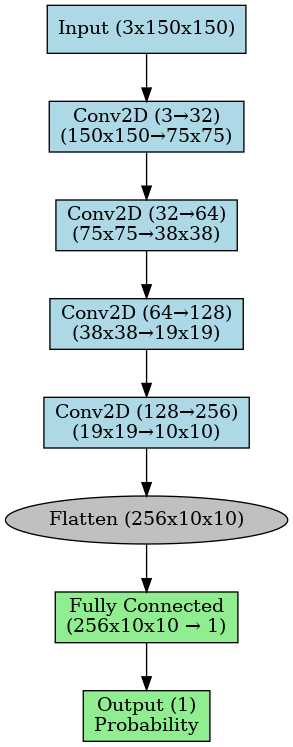

In [ ]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # (150, 150, 3) -> (75, 75, 32)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (75, 75, 32) -> (38, 38, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (38, 38, 64) -> (19, 19, 128)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (19, 19, 128) -> (10, 10, 256)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        )

        # Flatten layer and Linear (Fully connected) layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 10 * 10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [ ]:
discriminator = DiscriminatorModel()
total_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"Total Number of trainable parameters of this model are: {total_params:,}")
print(f'\n{discriminator}')

Total Number of trainable parameters of this model are: 414,913

DiscriminatorModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Dropout(p=0.25, inplace=F

In [ ]:
# Loss functions
def generator_loss(generated_images, real_images):
    return nn.MSELoss()(generated_images, real_images)

def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCELoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCELoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [ ]:
generator = GeneratorModel().to(device)
discriminator = DiscriminatorModel().to(device)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
SHUFFLE = True
MANUAL_SEED = 42

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

# Loss lists to track progress
gen_loss_list = []
disc_loss_list = []

# Training Loop
for epoch in range(EPOCHS):
    generator.train()
    discriminator.train()

    for batch_idx, (color_imgs, gray_imgs) in enumerate(trainloader):
        # Move data to the appropriate device
        color_imgs = color_imgs.to(device)  # Real colored images
        gray_imgs = gray_imgs.to(device)  # Grayscale images (input to generator)

        # ---------------------
        # Train Generator
        # ---------------------
        generator_optimizer.zero_grad()
        generated_imgs = generator(gray_imgs)  # Generate fake colored images
        fake_preds = discriminator(generated_imgs)  # Classify fake images
        gen_loss = generator_loss(generated_imgs, color_imgs)  # Compare to real images
        gen_loss.backward()
        generator_optimizer.step()

        # ---------------------
        # Train Discriminator
        # ---------------------
        discriminator_optimizer.zero_grad()
        real_preds = discriminator(color_imgs)  # Classify real images
        fake_preds = discriminator(generated_imgs.detach())  # Classify fake images (detached)
        disc_loss = discriminator_loss(real_preds, fake_preds)
        disc_loss.backward()
        discriminator_optimizer.step()

        # Store losses for analysis
        gen_loss_list.append(gen_loss.item())
        disc_loss_list.append(disc_loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx}/{len(trainloader)}], "
                  f"Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

    # Validation (optional)
    generator.eval()
    discriminator.eval()
    val_gen_loss, val_disc_loss = 0, 0
    with torch.no_grad():
        for color_imgs, gray_imgs in valloader:
            color_imgs = color_imgs.to(device)
            gray_imgs = gray_imgs.to(device)

            generated_imgs = generator(gray_imgs)
            fake_preds = discriminator(generated_imgs)
            real_preds = discriminator(color_imgs)

            val_gen_loss += generator_loss(generated_imgs, color_imgs).item()
            val_disc_loss += discriminator_loss(real_preds, fake_preds).item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Validation: "
          f"Gen Loss: {val_gen_loss/len(valloader):.4f}, "
          f"Disc Loss: {val_disc_loss/len(valloader):.4f}")


Epoch [1/10], Batch [0/312], Gen Loss: 0.0871, Disc Loss: 1.4345
Epoch [1/10], Batch [100/312], Gen Loss: 0.0268, Disc Loss: 0.3911
Epoch [1/10], Batch [200/312], Gen Loss: 0.0144, Disc Loss: 0.1379
Epoch [1/10], Batch [300/312], Gen Loss: 0.0183, Disc Loss: 0.0105
Epoch [1/10] Validation: Gen Loss: 0.0190, Disc Loss: 0.4958
Epoch [2/10], Batch [0/312], Gen Loss: 0.0226, Disc Loss: 0.0107
Epoch [2/10], Batch [100/312], Gen Loss: 0.0206, Disc Loss: 0.0045
Epoch [2/10], Batch [200/312], Gen Loss: 0.0132, Disc Loss: 0.0187
Epoch [2/10], Batch [300/312], Gen Loss: 0.0197, Disc Loss: 0.0025
Epoch [2/10] Validation: Gen Loss: 0.0164, Disc Loss: 0.8010
Epoch [3/10], Batch [0/312], Gen Loss: 0.0198, Disc Loss: 0.0016
Epoch [3/10], Batch [100/312], Gen Loss: 0.0175, Disc Loss: 0.0043
Epoch [3/10], Batch [200/312], Gen Loss: 0.0130, Disc Loss: 0.0061
Epoch [3/10], Batch [300/312], Gen Loss: 0.0165, Disc Loss: 0.0013
Epoch [3/10] Validation: Gen Loss: 0.0142, Disc Loss: 0.8009
Epoch [4/10], Batch

In [ ]:
def test(generator, discriminator, testloader, device):
    generator.eval()
    discriminator.eval()

    total_gen_loss = 0
    total_disc_loss = 0

    with torch.no_grad():
        for batch_idx, (color_imgs, gray_imgs) in enumerate(testloader):
            # Move data to the appropriate device
            color_imgs = color_imgs.to(device)  # Real colored images
            gray_imgs = gray_imgs.to(device)   # Grayscale images (input to generator)

            # Generate images using the generator
            generated_imgs = generator(gray_imgs)

            # Discriminator predictions
            real_preds = discriminator(color_imgs)  # Predictions on real images
            fake_preds = discriminator(generated_imgs)  # Predictions on generated images

            # Calculate losses
            gen_loss = generator_loss(generated_imgs, color_imgs)
            disc_loss = discriminator_loss(real_preds, fake_preds)

            total_gen_loss += gen_loss.item()
            total_disc_loss += disc_loss.item()

    # Calculate average loss over the test set
    avg_gen_loss = total_gen_loss / len(testloader)
    avg_disc_loss = total_disc_loss / len(testloader)

    print(f"Test Results: Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

    return avg_gen_loss, avg_disc_loss


In [ ]:
test_gen_loss, test_disc_loss = test(generator, discriminator, testloader, device)
print(f"Generator Loss on Test Set: {test_gen_loss}")
print(f"Discriminator Loss on Test Set: {test_disc_loss}")

Test Results: Generator Loss: 0.0091, Discriminator Loss: 4.1175
Generator Loss on Test Set: 0.009148701094090939
Discriminator Loss on Test Set: 4.11750772817811


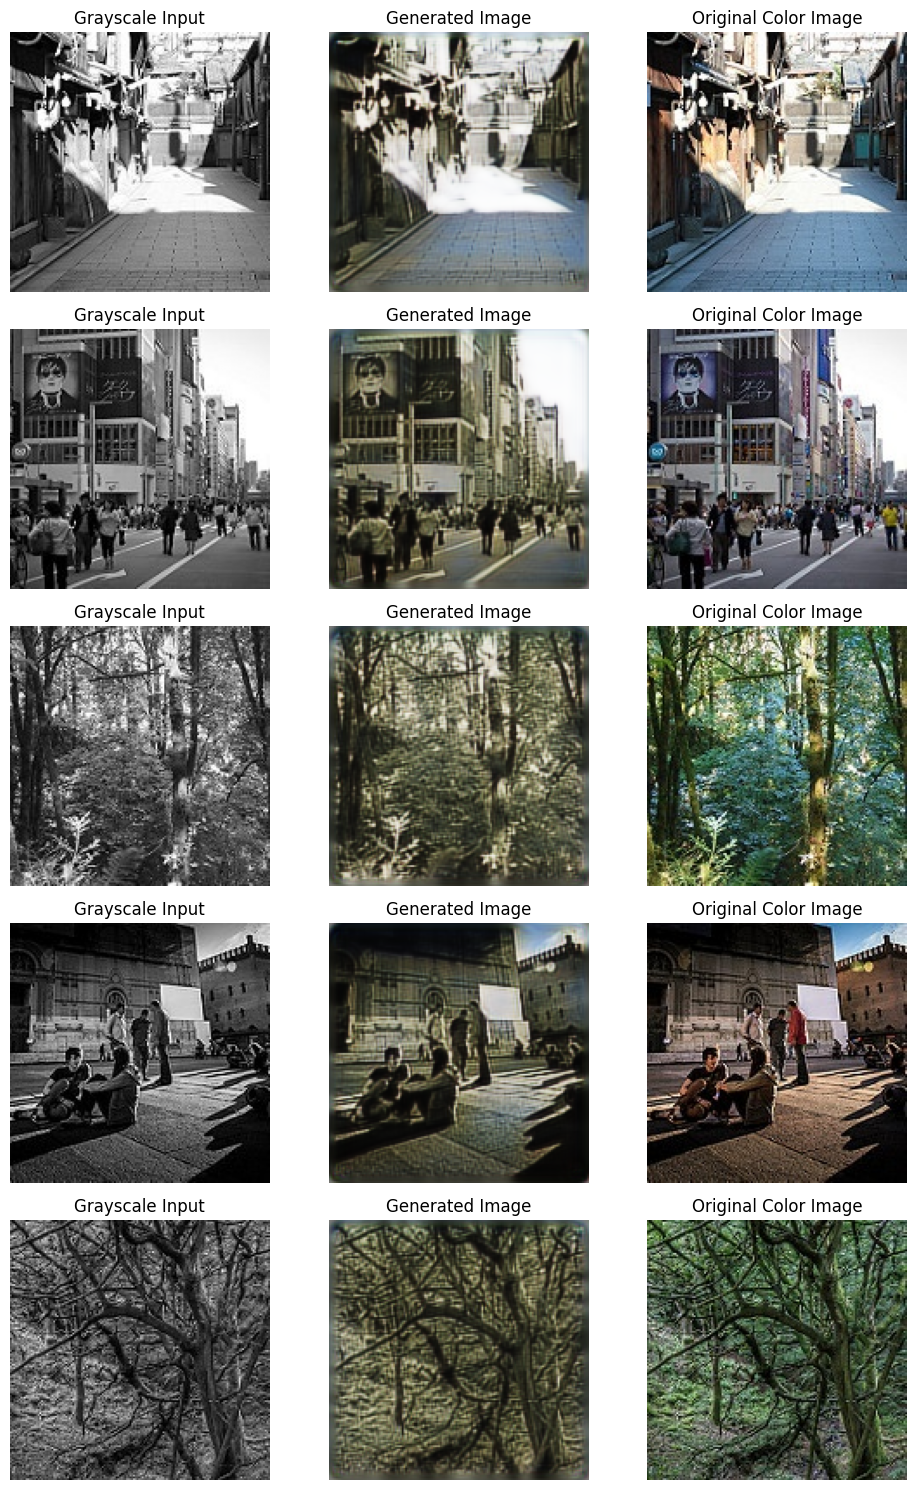

In [ ]:
def show_generated_images(generator, testloader, device, num_images=5):
    generator.eval()
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    with torch.no_grad():
        for i, (color_imgs, gray_imgs) in enumerate(testloader):
            if i >= num_images:
                break

            # Get a batch of images
            color_imgs = color_imgs.to(device)  # Real colored images
            gray_imgs = gray_imgs.to(device)   # Grayscale images

            # Generate images
            generated_imgs = generator(gray_imgs).cpu()

            # Convert to NumPy for visualization
            gray_img = gray_imgs[0].cpu().permute(1, 2, 0).numpy()
            real_img = color_imgs[0].cpu().permute(1, 2, 0).numpy()
            fake_img = generated_imgs[0].permute(1, 2, 0).numpy()

            # Display grayscale, generated, and real images
            axes[i, 0].imshow(gray_img.squeeze(), cmap="gray")
            axes[i, 0].set_title("Grayscale Input")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(fake_img)
            axes[i, 1].set_title("Generated Image")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(real_img)
            axes[i, 2].set_title("Original Color Image")
            axes[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

show_generated_images(generator, testloader, device, num_images=5)

## GAN Results
After training the GAN and testing it on new images, we observed the following results:

* **Landscape Images** – The model was able to add colors, but in some cases, the generated hues appeared too artificial, with deviations such as overly blue skies or grass with unnatural shades.

* **Buildings and Urban Scenes** – There were slight improvements in adding color to buildings, but sometimes the colors were inconsistent or bled into incorrect areas.

* **Complex Objects** – The model struggled to accurately identify colors in fine details, such as clothing or water reflections, and in some cases, there were significant discrepancies from the original images.

###Comparison Between U-Net and GAN

* U-Net produced more uniform and subtle colors, which in most cases aligned well with the overall structure of the image.

* GAN introduced more vibrant colors, but it also had errors in certain color tones, sometimes making the results appear less realistic.

* In some cases, GAN generated deeper and more dynamic colors, but there were instances where the colors did not match reality.

# Conclusion
While GAN can enhance certain aspects of image colorization, it is not always superior to U-Net alone. A combination of both approaches, along with additional fine-tuning and improved loss functions, could lead to better results in the future.